# **클러스터링 펙터란?**

- 물리적 디스크파일에서 데이터가 모여있는 정도를 나타낸다.
- 데이터베이스에서는 특정 컬럼을 기준으로 같은 값을 갖는 데이터가 서로 모여있는 정도를 의미.
- "인덱스 클러스터링 팩터가 좋다."고 하면 인덱스 정렬 순서와 테이블 정렬 순서가 서로 비슷하다는 것을 말한다.
- 예를들어 OLTP의 필수 컬럼으로 날짜가 있는데 데이터가 입력될때마다 날짜로 정렬하듯이 데이터가 입력.
  - 이것을 보고 날짜별 Clustering Factor가 좋다 함.
- 주의할점은 테이블에는 그저 날짜별로 입력이 된것일뿐 DBMS는 이것을 신뢰하지않고 날짜 컬럼으로 index를 만들어야 그 순서를 신뢰.
- 최소값 = 테이블 블록의 갯수 / 최대값 = 인덱스에 저장된 항목의 갯수


- 클러스터링 팩터의 영향
1. Index Scan의 Cost에 큰 영향을 준다.
  - 손익 분기점 이라고 부르며, 대개 Index 손익분기점은 5~20%.
  - 100개의 데이터중 5개~20개 까지가 인덱스로 스캔하기 적절하다는 뜻.
  - CF의 개입이 있는데 CF가 나쁠수록 손익분기점은 1%미만 까지 떨어질 수 있다. 반대로 CF가 좋을수록 90%수준까지 올라가기도 한다.
2. Index Lookup을 통해 Data를 읽는 일량을 결정한다.


- 클러스터링 팩터의 값의 계산

1. counter 변수를 선언.
2. 인덱스 리프 블록을 처음부터 끝까지 스캔하면서 인덱스 rowid로부터 블록 번호를 취함.
3. 현재 읽고 있는 인덱스 레코드의 블록 번호가 바로 직전에 읽은 레코드의 블록 번호와 다를 때마다 counter값을 1씩 증가.
4. 스캔을 완료하고서, 최종 counter변수 값을 clustering_factor로서 인덱스 통계에 저장.
테이블 통계를 수집하지 않고, clustering_factor를 구하는 스크립트 실행

**클러스터링 펙터가 좋다면?**

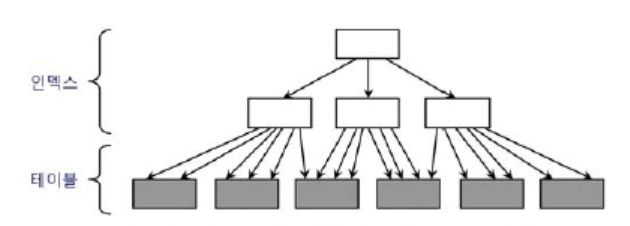

- 위그림은 클러스터링 펙터가 좋은 예이다.
- 인덱스의 논리적 순서와 테이블의 물리적 순서가 완벽히 일치.
- 인덱스에서 Rowid로 가져온 하나의 블록을 버퍼캐시에 적재할때, 다음 Rowid도 미리 적재된 블록을 가리킬 확률이 매우 높다
  - 물리적 디스크I/O를 현격히 떨어트린다.



**클러스터링 펙터가 나쁘면?**

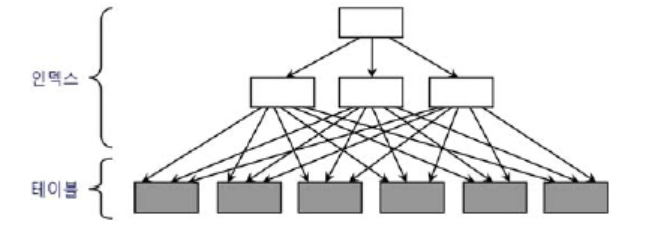

- 위는 클러스터링 펙터가 나쁜 예.
- Index Range Scan시 Single Block IO로 인해 가져온 하나의 물리적 블록이 바로 다음 Scan에서는 전혀다른 블록을 가리킨다.
- 매번 조회마다 새로운 블록을 검색하고 적재하며 버퍼캐시에서 밀려나는 행위가 반복된다
  - 물리적 디스크 I/O를 최대치로 높힌다.



- 1000개의 데이터가 index와 같은 순서로 되어있을 경우
  - 클러스터링 팩터 : 4

```sql
SQL> create table t1(col1 number, col2 varchar2(10));
SQL> insert into t1
     select level, 'test'
     from dual
     connect by level <= 1000;

```


```sql
SQL> select index_name, table_owner, table_name, clustering_factor
     from user_indexes
     where index_name = 'T1_COL1_IDX';

```



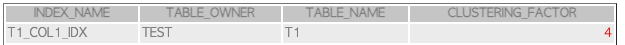

- 1000개의 데이터가 index와 정반대의 순서로 되어있을 경우
  - 클러스터링 팩터 : 4

```sql
SQL> create table t2(col1 number, col2 varchar2(10));
SQL> insert into t2
     select 1001-level, 'test'
     from dual
     connect by level <=1000;
SQL> create index t2_col1_idx on t2(col1);
```


```sql
SQL> select index_name, table_owner, table_name, clustering_factor
     from user_indexes
     where index_name = 'T2_COL1_IDX';

```



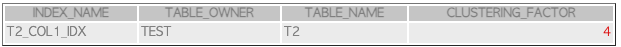

- 1000개의 데이터가 랜덤으로 되어있을 경우
  - 클러스터링 팩터 : 881

```sql
SQL> create table t3(col1 number, col2 varchar2(10));
SQL> insert into t3
     select dbms_random.value(1,1000), 'test'
     from dual
     connect by level <= 1000;
SQL> create index t2_col1_idx on t3(col1);\

```


```sql
SQL> select index_name, table_owner, table_name, clustering_factor
     from user_indexes
     where index_name = 'T3_COL1_IDX';

```



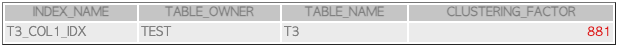